In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from category_encoders import BinaryEncoder, cat_boost
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def scores(estimator, X_train, y_train, X_test, y_test, threshold=0.5, plot=True):
    if threshold:
        pred_proba = estimator.predict_proba(X_test)
        y_test_pred = np.where(pred_proba[:, 1] > threshold, 1, 0)
    else:
        y_test_pred = estimator.predict(X_test)


    # calculate metrics
    print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_test_pred)))
    print('Testing precision = {}'.format(metrics.precision_score(y_test, y_test_pred)))
    print('Testing recall = {}'.format(metrics.recall_score(y_test, y_test_pred)))
    print('Testing f1_score = {}'.format(metrics.f1_score(y_test, y_test_pred)))
  
    if plot: 
        cm = confusion_matrix(y_test, y_test_pred, labels=estimator.classes_, 
                        #   normalize='true'
                        )
        ConfusionMatrixDisplay(cm, display_labels=estimator.classes_).plot()
        return cm
    

# Preprocess the data

In [2]:
data_features = ['date_create','order_start_prepare','order_ready','order_pickup']
without_outliers = '_wtht_outls_sorted_dates'
X_train = pd.read_csv(f'../content/train{without_outliers}.csv', parse_dates=data_features)
X_test = pd.read_csv(f'../content/test{without_outliers}.csv', parse_dates=data_features)

In [3]:
def type_casting(df):
    cat_features = ['store_id','region_id','status_id']
    float_feats = ['profit','order_price','max_price','min_price','avg_price','planned_prep_time']
    int_feats = ['delivery_distance','products_count','unique_products_sold_by_store']
    df[cat_features] = df[cat_features].astype('object')
    df[float_feats] = df[float_feats].astype('float')
    df[int_feats] = df[int_feats].astype('int')
    return df

X_train = type_casting(X_train)
X_test = type_casting(X_test)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440204 entries, 0 to 440203
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   store_id                       440204 non-null  object        
 1   profit                         396393 non-null  float64       
 2   delivery_distance              440204 non-null  int64         
 3   date_create                    439978 non-null  datetime64[ns]
 4   order_start_prepare            396148 non-null  datetime64[ns]
 5   planned_prep_time              440203 non-null  float64       
 6   order_ready                    396478 non-null  datetime64[ns]
 7   order_pickup                   440204 non-null  datetime64[ns]
 8   region_id                      440204 non-null  object        
 9   status_id                      440204 non-null  object        
 10  products_count                 440204 non-null  int64         
 11  

In [4]:
def impute_dates_by_store(x):
    diff_date = x['order_start_prepare'] - x['date_create']
    median_diff = diff_date[diff_date > pd.to_timedelta("0 days")].median()
    x.loc[x['order_start_prepare'].isnull(), 'order_start_prepare'] = x.loc[x['order_start_prepare'].isnull(), 'date_create'] + median_diff
    x.loc[x['date_create'].isnull(), 'date_create'] = x.loc[x['date_create'].isnull(), 'order_start_prepare'] - median_diff

    diff_date = x['order_pickup'] - x['order_ready']
    median_diff = diff_date[diff_date > pd.to_timedelta("0 days")].median()
    x.loc[x['order_pickup'].isnull(), 'order_pickup'] = x.loc[x['order_pickup'].isnull(), 'order_ready'] + median_diff
    x.loc[x['order_ready'].isnull(), 'order_ready'] = x.loc[x['order_ready'].isnull(), 'order_pickup'] - median_diff
    return x

def impute_df(df):
    df.loc[:,['date_create','order_start_prepare','order_ready','order_pickup']] = df.groupby("store_id")\
            .apply(lambda x: impute_dates_by_store(x))\
            .reset_index(allow_duplicates=True)\
            .set_index('level_1')[['date_create','order_start_prepare','order_ready','order_pickup']]
    return df
    
X_train = impute_df(X_train)
X_test = impute_df(X_test)

In [5]:
def extract_target(df):
    df['actual_prep_time'] = (df['order_ready'] - df['order_start_prepare']).dt.total_seconds() / 60
    print("Nan's in actual_prep_time: ", df['actual_prep_time'].isna().sum(),
          "\nNegatives: ", (df['actual_prep_time'] < 0).sum())
    anomaly_diff_mask = (df['actual_prep_time'] < 0) | df['actual_prep_time'].isnull() 
    print(df.loc[anomaly_diff_mask].shape)
    df = df.loc[~anomaly_diff_mask]
    df.dropna(subset=['date_create','planned_prep_time'], inplace=True)
    df['on_time'] = np.where(abs(df['planned_prep_time'] - df['actual_prep_time']) <= 5, 1, 0)
    return df.drop(columns=['order_ready','order_pickup','actual_prep_time','planned_prep_time','on_time']), df['on_time']

X_train, y_train = extract_target(X_train)
X_test, y_test = extract_target(X_test)
data_features = ['date_create','order_start_prepare']

Nan's in actual_prep_time:  30 
Negatives:  247
(277, 17)
Nan's in actual_prep_time:  14 
Negatives:  27
(41, 17)


In [6]:
def encode_cyclical_feat(data: pd.DataFrame, col: pd.Series, col_name: str):
    data[col_name + '_sin'] = np.sin(2 * np.pi * col/col.max())
    data[col_name + '_cos'] = np.cos(2 * np.pi * col/col.max())
    return data

def extract_date_feat(df, data_features):
    for col_name in data_features:
        df = encode_cyclical_feat(df, df[col_name].dt.month, col_name + '_month')
        df = encode_cyclical_feat(df, df[col_name].dt.day, col_name + '_day')
        df = encode_cyclical_feat(df, df[col_name].dt.weekday, col_name + '_weekday')
        df = encode_cyclical_feat(df, df[col_name].dt.hour, col_name + '_hour')
        df = encode_cyclical_feat(df, df[col_name].dt.minute, col_name + '_minute')
    df = df.drop(columns=data_features)
    return df

X_train = extract_date_feat(X_train, data_features)
X_test = extract_date_feat(X_test, data_features)
X_train.columns

Index(['store_id', 'profit', 'delivery_distance', 'region_id', 'status_id',
       'products_count', 'order_price', 'max_price', 'min_price', 'avg_price',
       'unique_products_sold_by_store', 'date_create_month_sin',
       'date_create_month_cos', 'date_create_day_sin', 'date_create_day_cos',
       'date_create_weekday_sin', 'date_create_weekday_cos',
       'date_create_hour_sin', 'date_create_hour_cos',
       'date_create_minute_sin', 'date_create_minute_cos',
       'order_start_prepare_month_sin', 'order_start_prepare_month_cos',
       'order_start_prepare_day_sin', 'order_start_prepare_day_cos',
       'order_start_prepare_weekday_sin', 'order_start_prepare_weekday_cos',
       'order_start_prepare_hour_sin', 'order_start_prepare_hour_cos',
       'order_start_prepare_minute_sin', 'order_start_prepare_minute_cos'],
      dtype='object')

<Axes: ylabel='on_time'>

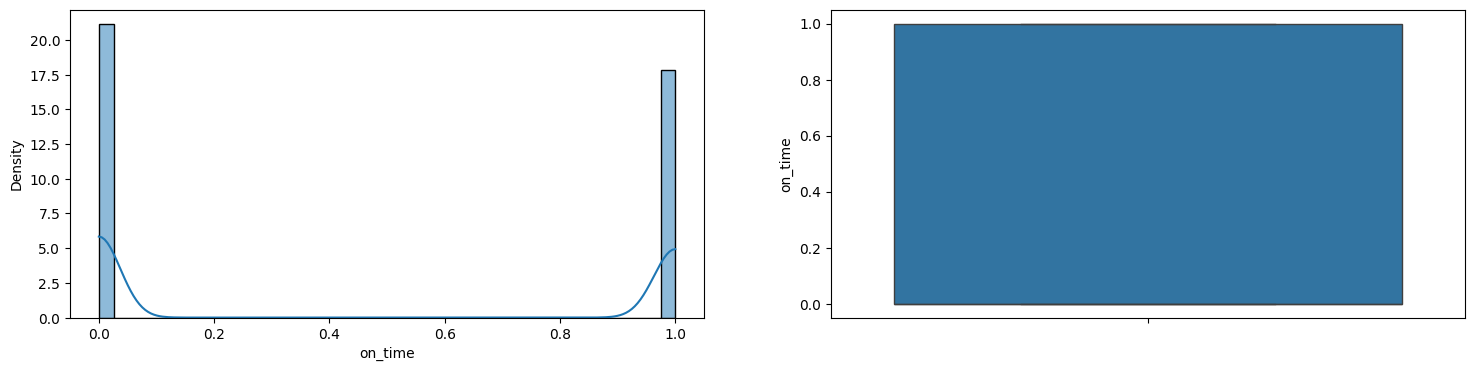

In [7]:
_, axes = plt.subplots(1, 2, figsize=(18, 4))

sns.histplot(y_train, 
             stat='density', 
			 kde=True,
            #  bins=35
            ax=axes[0]
             )
sns.boxplot(data=y_train, ax=axes[1])

In [8]:
na_columns_train = X_train.columns[X_train.isna().any()]
print(na_columns_train)
na_columns_test = X_test.columns[X_test.isna().any()]
print(na_columns_test)

Index(['profit', 'max_price', 'min_price', 'avg_price'], dtype='object')
Index(['profit', 'max_price', 'min_price', 'avg_price'], dtype='object')


In [9]:
X_train.loc[:,na_columns_train] = X_train.groupby("store_id")[na_columns_train].transform(lambda x: x.fillna(x.mode()))
X_test.loc[:,na_columns_test] = X_test.groupby("store_id")[na_columns_test].transform(lambda x: x.fillna(x.mode()))

In [10]:
# ###################################### Imputting #####################################
from sklearn.impute import SimpleImputer
col_imputing = X_test.columns[X_test.isna().any()].intersection(X_train.columns[X_train.isna().any()])
print(col_imputing)

imputer = SimpleImputer(strategy='most_frequent')
X_train[col_imputing] = pd.DataFrame(imputer.fit_transform(X_train[col_imputing]), columns=col_imputing, index=X_train.index)
X_test[col_imputing] = pd.DataFrame(imputer.transform(X_test[col_imputing]), columns=col_imputing, index=X_test.index)

Index(['profit', 'max_price', 'min_price', 'avg_price'], dtype='object')


In [11]:
###################################### Encoding #####################################
cat_features = ['store_id','region_id','status_id']
encoder = cat_boost.CatBoostEncoder(cols=cat_features, random_state=42)
X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test, y_test)

In [12]:
##################################### Scaling #####################################
scaler = preprocessing.RobustScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=scaler.get_feature_names_out())
X_test = pd.DataFrame(scaler.transform(X_test), columns=scaler.get_feature_names_out())

# EDA for classification

In [ ]:
# plt.pie(y_train.values, labels=y_train.map({0:'Late', 1:"On time"}), autopct='%0.01f%%')

# sns.catplot(
#     x="on_time",
#     y="products",
#     col="region_id",
#     data=X_train,
#     kind="box",
#     col_wrap=4,
#     height=3,
#     aspect=0.8,
# )

# Models

## Logistic Regression

----Logistic Regression Coefficients----
('store_id', np.float64(0.39546559793656183))
('profit', np.float64(0.004326734032348814))
('delivery_distance', np.float64(-0.05002353709890465))
('region_id', np.float64(0.027979213596723153))
('status_id', np.float64(0.0014718730060093524))
('products_count', np.float64(-0.0030011365509164134))
('order_price', np.float64(-0.0013236344286944052))
('max_price', np.float64(0.007569697595001332))
('min_price', np.float64(0.0063860105532914345))
('avg_price', np.float64(0.02190747356094681))
('unique_products_sold_by_store', np.float64(-0.016954018696127133))
('date_create_month_sin', np.float64(-0.0010088927274971662))
('date_create_month_cos', np.float64(5.824329594387903e-05))
('date_create_day_sin', np.float64(0.005587332227331532))
('date_create_day_cos', np.float64(-0.004936189352755896))
('date_create_weekday_sin', np.float64(0.014600564716974516))
('date_create_weekday_cos', np.float64(0.0032695946342211945))
('date_create_hour_sin', np.fl

array([[19102,  7523],
       [13740,  8505]])

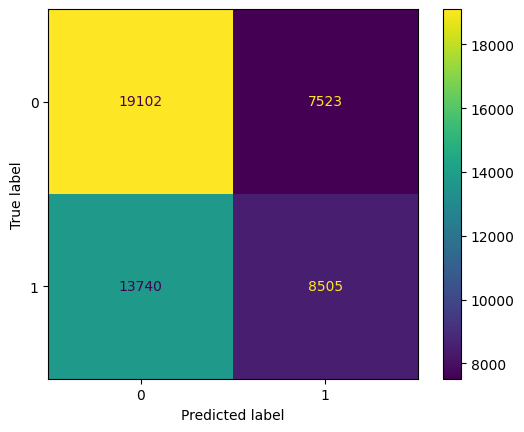

In [20]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=42).fit(X_train, y_train)

print("----Logistic Regression Coefficients----")
print(*[a for a in zip(list(X_train.columns), clf.coef_[0])], sep='\n', end='\n\n\n')

scores(clf, X_train, y_train, X_test, y_test)

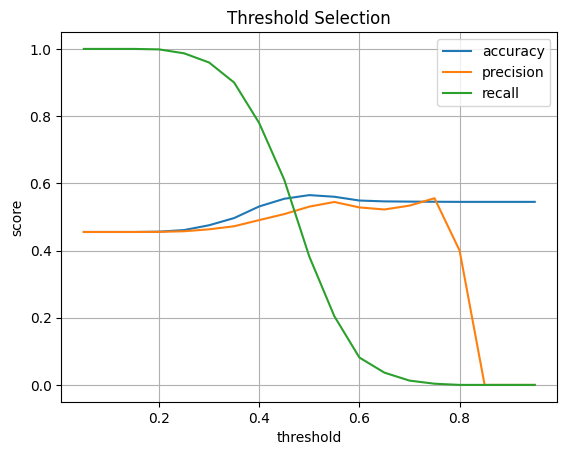

In [21]:
thresholds = np.arange(0.05, 0.99, 0.05)
pred_proba = clf.predict_proba(X_test)

results = [[],[],[]]
for i in thresholds:
    y_test_pred_thr = np.where(pred_proba[:, 1] > i, 1, 0)
    results[0].append(metrics.accuracy_score(y_test, y_test_pred_thr)) # accuracy 
    results[1].append(metrics.precision_score(y_test, y_test_pred_thr)) # precision
    results[2].append(metrics.recall_score(y_test, y_test_pred_thr)) # recall
    
plt.plot(thresholds, results[0], label = 'accuracy')   
plt.plot(thresholds, results[1], label = 'precision')   
plt.plot(thresholds, results[2], label = 'recall')
plt.title('Threshold Selection')
plt.xlabel('threshold')
plt.ylabel('score')
plt.legend()
plt.grid()

Testing accuracy = 0.5311643134847555
Testing precision = 0.490564970153054
Testing recall = 0.7795010114632501
Testing f1_score = 0.6021669676343937


array([[ 8618, 18007],
       [ 4905, 17340]])

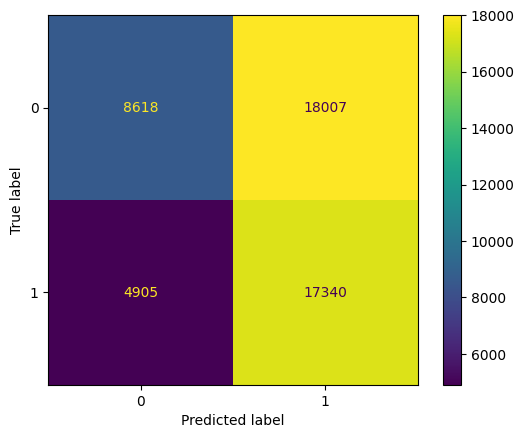

In [22]:
scores(clf, X_train, y_train, X_test, y_test, 0.4)

## SVC

In [24]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA

In [43]:
n_components = range(len(X_train.columns)-3, len(X_train.columns)+1)
for component in n_components:
    pca = PCA(n_components=component, random_state=42)
    X_train_svc = pca.fit_transform(X_train)
    X_test_svc = pca.transform(X_test)

    svc = SVC(kernel='rbf', degree=4, C=1, max_iter=100)
    svc.fit(X_train_svc, y_train)

    # print("Support vectors: ", svc.support_vectors_) # get support vectors
    # print("indices of support vectors: ", svc.support_) # get indices of support vectors
    print("\nnumber of support vectors for each class: ", svc.n_support_,'\n\n') # get number of support vectors for each class

    scores(svc, X_train_svc, y_train, 
                X_test_svc, y_test, threshold=None, plot=False)


number of support vectors for each class:  [100 100] 


Testing accuracy = 0.5245549416820136
Testing precision = 0.4628043282236249
Testing recall = 0.27687120701281187
Testing f1_score = 0.34646865243439373

number of support vectors for each class:  [100 100] 


Testing accuracy = 0.5245549416820136
Testing precision = 0.4628043282236249
Testing recall = 0.27687120701281187
Testing f1_score = 0.34646865243439373

number of support vectors for each class:  [100 100] 


Testing accuracy = 0.5245549416820136
Testing precision = 0.4628043282236249
Testing recall = 0.27687120701281187
Testing f1_score = 0.34646865243439373

number of support vectors for each class:  [100 100] 


Testing accuracy = 0.5245549416820136
Testing precision = 0.4628043282236249
Testing recall = 0.27687120701281187
Testing f1_score = 0.34646865243439373


Testing accuracy = 0.5245549416820136
Testing precision = 0.4628043282236249
Testing recall = 0.27687120701281187
Testing f1_score = 0.34646865243439373


array([[19476,  7149],
       [16086,  6159]])

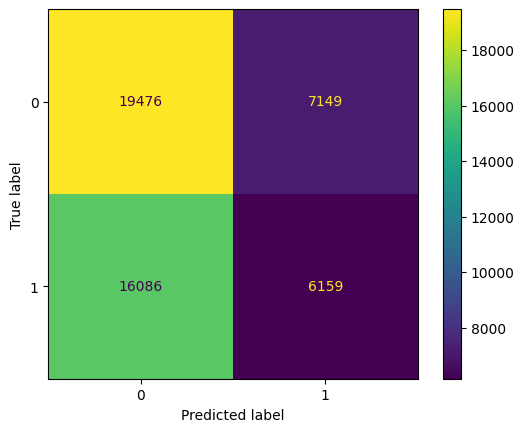

In [45]:
scores(svc, X_train_svc, y_train, 
                X_test_svc, y_test, threshold=None, plot=True)

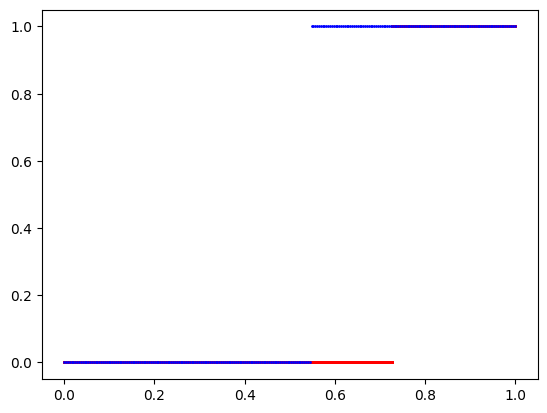

In [46]:
y_pred = svc.predict(X_test_svc)
eval_df = pd.DataFrame({'Actual': y_test.reset_index(drop=True), 'Predicted': pd.Series(y_pred.tolist()).explode()})
x_axis = np.linspace(0, eval_df['Predicted'].max(), len(eval_df))
plt.scatter(x_axis, eval_df['Predicted'].sort_values(), s=1, c='r')
plt.scatter(x_axis[::200], eval_df['Actual'].sort_values()[::200], s=1, c='b')

## Neural Network (MLP)

In [47]:
import torch
from torch import nn, optim

In [90]:
selected_features = ['store_id', 'profit', 'delivery_distance', 'region_id', 'status_id',
       'products_count', 'order_price',
       'unique_products_sold_by_store',
       'order_start_prepare_hour_sin', 'order_start_prepare_hour_cos']

In [91]:
X_train_sel, X_test_sel = X_train[selected_features], X_test[selected_features]

In [92]:
X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = (torch.tensor(batch.values, dtype=torch.float32, device='cuda') 
                                                                for batch 
                                                                in (X_train_sel, X_test_sel, y_train, y_test))

type(X_train_tensor), X_train_tensor.shape, type(y_train_tensor), y_train_tensor.shape

(torch.Tensor, torch.Size([439926, 10]), torch.Tensor, torch.Size([439926]))

In [93]:
model = nn.Sequential(nn.LazyLinear(10), nn.ReLU(), 
                      nn.LazyLinear(32), nn.ReLU(), 
                      nn.LazyLinear(8), nn.ReLU(), 
                      # nn.LazyLinear(32), nn.ReLU(), 
                      nn.LazyLinear(1), nn.ReLU(), nn.Dropout(p=0.5))
model = model.to('cuda')


mean_train_losses = []
mean_valid_losses = []
valid_acc_list = []

In [101]:
epochs = 1000
lr = 0.00001

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0)


for epoch in range(epochs):
    model.train()
    
    train_losses = []
    valid_losses = []
    optimizer.zero_grad()
    outputs = model(X_train_tensor).squeeze()
    loss = loss_fn(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    mean_train_losses.append(np.mean(train_losses))
   
    print('epoch : {}, train loss : {:.4f}'\
         .format(epoch+1, np.mean(train_losses)))


epoch : 1, train loss : 2618585.0000
epoch : 2, train loss : 2618585.0000
epoch : 3, train loss : 2618585.0000
epoch : 4, train loss : 2618585.0000
epoch : 5, train loss : 2618585.0000
epoch : 6, train loss : 2618585.0000
epoch : 7, train loss : 2618585.0000
epoch : 8, train loss : 2618585.0000
epoch : 9, train loss : 2618585.0000
epoch : 10, train loss : 2618585.0000
epoch : 11, train loss : 2618585.0000
epoch : 12, train loss : 2618585.0000
epoch : 13, train loss : 2618585.0000
epoch : 14, train loss : 2618585.0000
epoch : 15, train loss : 2618585.0000
epoch : 16, train loss : 2618585.0000
epoch : 17, train loss : 2618585.0000
epoch : 18, train loss : 2618585.0000
epoch : 19, train loss : 2618585.0000
epoch : 20, train loss : 2618585.0000
epoch : 21, train loss : 2618585.0000
epoch : 22, train loss : 2618585.0000
epoch : 23, train loss : 2618585.0000
epoch : 24, train loss : 2618585.0000
epoch : 25, train loss : 2618585.0000
epoch : 26, train loss : 2618585.0000
epoch : 27, train los

In [103]:
pred_proba

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

Testing accuracy = 0.5448127685696746
Testing precision = 0.0
Testing recall = 0.0
Testing f1_score = 0.0

Testing accuracy = 0.5448127685696746
Testing precision = 0.0
Testing recall = 0.0
Testing f1_score = 0.0

Testing accuracy = 0.5448127685696746
Testing precision = 0.0
Testing recall = 0.0
Testing f1_score = 0.0

Testing accuracy = 0.5448127685696746
Testing precision = 0.0
Testing recall = 0.0
Testing f1_score = 0.0

Testing accuracy = 0.5448127685696746
Testing precision = 0.0
Testing recall = 0.0
Testing f1_score = 0.0

Testing accuracy = 0.5448127685696746
Testing precision = 0.0
Testing recall = 0.0
Testing f1_score = 0.0

Testing accuracy = 0.5448127685696746
Testing precision = 0.0
Testing recall = 0.0
Testing f1_score = 0.0

Testing accuracy = 0.5448127685696746
Testing precision = 0.0
Testing recall = 0.0
Testing f1_score = 0.0

Testing accuracy = 0.5448127685696746
Testing precision = 0.0
Testing recall = 0.0
Testing f1_score = 0.0

Testing accuracy = 0.5448127685696746

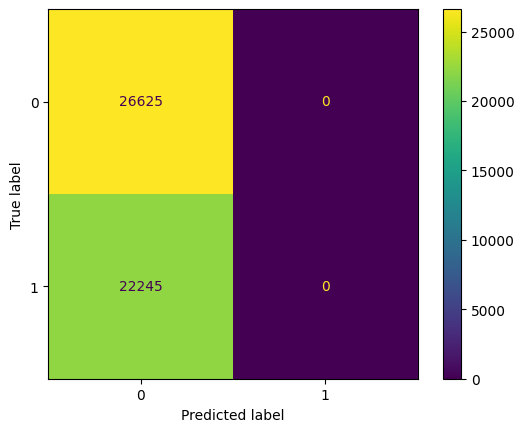

In [102]:
model = model.eval()
model = model.to('cuda')

pred_proba = model(X_test_tensor)
pred_proba = pred_proba.to('cpu').detach().numpy()

best_threshold, prev_precision = 0.3, 0
for threshold in np.linspace(0.3, 0.9, 10):

    y_test_pred = np.where(pred_proba > threshold, 1, 0)
    # calculate metrics
    print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_test_pred)))
    precision = metrics.precision_score(y_test, y_test_pred)
    print('Testing precision = {}'.format(precision))
    if precision > prev_precision:
        best_threshold = threshold
    print('Testing recall = {}'.format(metrics.recall_score(y_test, y_test_pred)))
    print('Testing f1_score = {}'.format(metrics.f1_score(y_test, y_test_pred)), end='\n\n')

y_test_pred = np.where(pred_proba > best_threshold, 1, 0)
cm = confusion_matrix(y_test, y_test_pred, labels=[0,1], 
                #   normalize='true'
                )
ConfusionMatrixDisplay(cm, display_labels=[0,1]).plot()